# numpyro

In [1]:
use_cuda = False

In [2]:
# import pymc3 as pm
import numpy as np
import pandas as pd
# from theano import shared
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az

In [3]:
az.style.use('arviz-darkgrid')

In [4]:
import torch
import jax
import jax.numpy as jnp
from jax import lax, ops, random

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary, summary, hpdi
from numpyro.infer import MCMC, NUTS, SVI, Trace_ELBO, init_to_value, Predictive
from numpyro.infer.autoguide import AutoLaplaceApproximation

numpyro.set_host_device_count(4)

# choice GPU or CPU
if use_cuda and torch.cuda.is_available():
    numpyro.set_platform("gpu")
    print("jax backend {}".format(jax.lib.xla_bridge.get_backend().platform))
else:
    print("jax backend {}".format(jax.lib.xla_bridge.get_backend().platform))

jax backend cpu


## Simple linear regression

In [5]:
np.random.seed(1)
N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real * x
y = y_real + eps_real

# we can center the data
#x = x - x.mean()
# or standardize the data
#x = (x - x.mean())/x.std()
#y = (y - y.mean())/y.std()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  


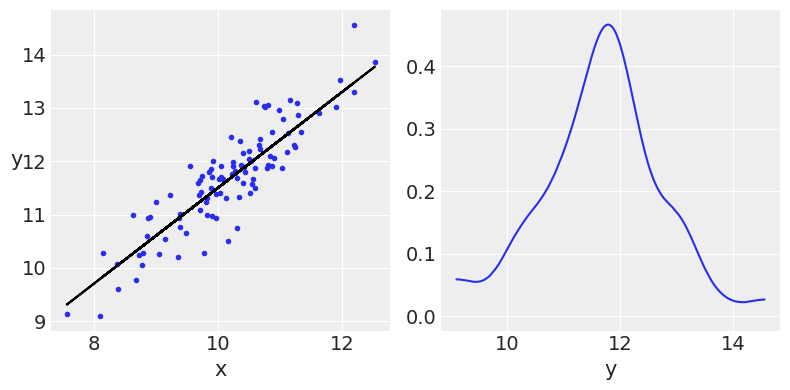

In [6]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(x, y, 'C0.')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].plot(x, y_real, 'k')
az.plot_kde(y, ax=ax[1])
ax[1].set_xlabel('y')
plt.tight_layout()
plt.savefig('B11197_03_02.png', dpi=300)

In [23]:
def model_g(x, y=None):
    alpha = numpyro.sample('alpha', dist.Normal(loc=0, scale=10))
    beta = numpyro.sample('beta', dist.Normal(loc=0, scale=1))
    eps = numpyro.sample('eps', dist.HalfCauchy(5.))
    
    mu = alpha + beta * x
    
    numpyro.sample("obs", dist.Normal(loc=mu, scale=eps), obs=y)

In [24]:
random.PRNGKey(0)

DeviceArray([0, 0], dtype=uint32)

In [25]:
rng_key = random.PRNGKey(0)
# rng_key, rng_key_ = random.split(rng_key)

In [139]:
x=jnp.array(x)
y=jnp.array(y)

### MCMC

In [140]:
%%time

nuts_kernel = NUTS(model_g)
mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=1000, num_chains=4)
mcmc.run(rng_key, x, y)
posterior_samples = mcmc.get_samples()

CPU times: user 4.99 s, sys: 0 ns, total: 4.99 s
Wall time: 4.74 s


In [141]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      2.12      0.49      2.12      1.29      2.90   2460.31      1.00
      beta      0.94      0.05      0.94      0.86      1.02   2460.78      1.00
       eps      0.45      0.03      0.45      0.40      0.51   3070.90      1.00

Number of divergences: 0


In [142]:
posterior_samples

{'alpha': DeviceArray([2.5961092, 2.4290323, 2.494448 , ..., 1.7766142, 2.4383316,
              2.1783512], dtype=float32),
 'beta': DeviceArray([0.8928689 , 0.9113453 , 0.90256774, ..., 0.97121835,
              0.9012023 , 0.9342022 ], dtype=float32),
 'eps': DeviceArray([0.4111469 , 0.36248007, 0.40817544, ..., 0.4699264 ,
              0.41080824, 0.4022454 ], dtype=float32)}

In [143]:
predictive = Predictive(model_g, posterior_samples)
posterior_predictive = predictive(random.PRNGKey(1), x=x)
posterior_predictive

{'obs': DeviceArray([[11.1473465, 12.649971 , 11.931565 , ..., 11.901393 ,
               11.782019 , 12.277553 ],
              [11.59758  , 13.216928 , 12.647508 , ..., 11.471665 ,
               12.517115 , 12.090917 ],
              [11.086205 , 13.122799 , 12.394952 , ..., 11.572966 ,
               11.982601 , 12.657518 ],
              ...,
              [11.636473 , 13.2978115, 11.935371 , ..., 11.343054 ,
               12.652852 , 12.912777 ],
              [11.167707 , 12.13874  , 11.781452 , ..., 11.723383 ,
               11.964999 , 12.825204 ],
              [11.502483 , 12.1007395, 11.499229 , ..., 12.61557  ,
               12.160995 , 12.829118 ]], dtype=float32)}

### Summary table

#### version 1

In [144]:
# https://pyro.ai/examples/baseball.html
def get_summary_table(posterior, sites, diagnostics=False, group_by_chain=False, prob=0.9):
    """
    Return summarized statistics for each of the ``sites`` in the
    traces corresponding to the approximate posterior.
    """
    site_stats = {}

    for site_name in sites:
        marginal_site = posterior[site_name]
        site_summary = summary({site_name: marginal_site}, prob=prob, group_by_chain=group_by_chain)[site_name]
        if site_summary["mean"].shape:
            site_df = pd.DataFrame(site_summary)
        else:
            site_df = pd.DataFrame(site_summary, index=[0])
        if not diagnostics:
            site_df = site_df.drop(["n_eff", "r_hat"], axis=1)
        site_stats[site_name] = site_df.astype(float)

    return site_stats

In [145]:
get_summary_table(posterior_predictive, ['obs'])

{'obs':          mean       std     median       5.0%      95.0%
 0   11.102082  0.454186  11.098370  10.366289  11.852025
 1   12.676088  0.454384  12.676764  11.899408  13.392522
 2   11.908622  0.448051  11.907762  11.156866  12.621243
 3   12.079506  0.464077  12.080237  11.295064  12.802410
 4   10.489655  0.459079  10.487228   9.727669  11.231999
 ..        ...       ...        ...        ...        ...
 95   9.998590  0.461621   9.997622   9.257747  10.777186
 96  12.086266  0.450860  12.084517  11.332096  12.829930
 97  11.918579  0.451889  11.919981  11.187614  12.665692
 98  12.283934  0.458845  12.282611  11.521864  13.031979
 99  12.500134  0.455463  12.500798  11.790616  13.280586
 
 [100 rows x 5 columns]}

In [146]:
get_summary_table(posterior_samples, ['alpha', 'beta', 'eps'])

{'alpha':        mean       std    median      5.0%     95.0%
 0  2.121399  0.487268  2.116817  1.291749  2.899683,
 'beta':        mean       std    median      5.0%     95.0%
 0  0.940262  0.047776  0.940984  0.860736  1.017862,
 'eps':        mean       std    median      5.0%     95.0%
 0  0.450978  0.032519  0.448732  0.399491  0.505096}

#### version 2

In [147]:
def get_summary_table_pandas(posterior, sites, percentiles=[.05, 0.25, 0.5, 0.75, 0.95]):
    site_stats = {}

    for site_name in sites:
        values = posterior[site_name]
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=percentiles).transpose()
        site_stats[site_name] = describe.astype(float)
    return site_stats

In [148]:
get_summary_table_pandas(posterior_predictive, ['obs'], percentiles=[.05, 0.95])

{'obs':      count       mean       std        min         5%        50%        95%  \
 0   8000.0  11.102083  0.454186   9.432884  10.358671  11.098370  11.846461   
 1   8000.0  12.676073  0.454384  10.824471  11.928417  12.676764  13.428237   
 2   8000.0  11.908598  0.448051  10.206566  11.172299  11.907762  12.639550   
 3   8000.0  12.079506  0.464077  10.310828  11.324836  12.080237  12.841111   
 4   8000.0  10.489638  0.459079   8.870085   9.738283  10.487229  11.249927   
 ..     ...        ...       ...        ...        ...        ...        ...   
 95  8000.0   9.998599  0.461621   7.560266   9.229880   9.997622  10.752391   
 96  8000.0  12.086264  0.450861  10.493001  11.327161  12.084517  12.827858   
 97  8000.0  11.918613  0.451889  10.352556  11.176921  11.919981  12.659014   
 98  8000.0  12.283899  0.458845  10.301384  11.524990  12.282611  13.036479   
 99  8000.0  12.500149  0.455462  10.822960  11.747736  12.500798  13.247126   
 
           max  
 0   12.703705

In [149]:
get_summary_table_pandas(posterior_samples, ['alpha', 'beta', 'eps'], percentiles=[.05, 0.95])

{'alpha':     count    mean       std       min        5%       50%       95%       max
 0  8000.0  2.1214  0.487268  0.599994  1.330955  2.116817  2.942632  3.825962,
 'beta':     count      mean       std       min        5%       50%       95%  \
 0  8000.0  0.940262  0.047776  0.768841  0.859975  0.940984  1.017481   
 
         max  
 0  1.087523  ,
 'eps':     count      mean       std       min        5%       50%       95%  \
 0  8000.0  0.450978  0.032519  0.361407  0.401112  0.448732  0.507388   
 
         max  
 0  0.593457  }

### plot trace

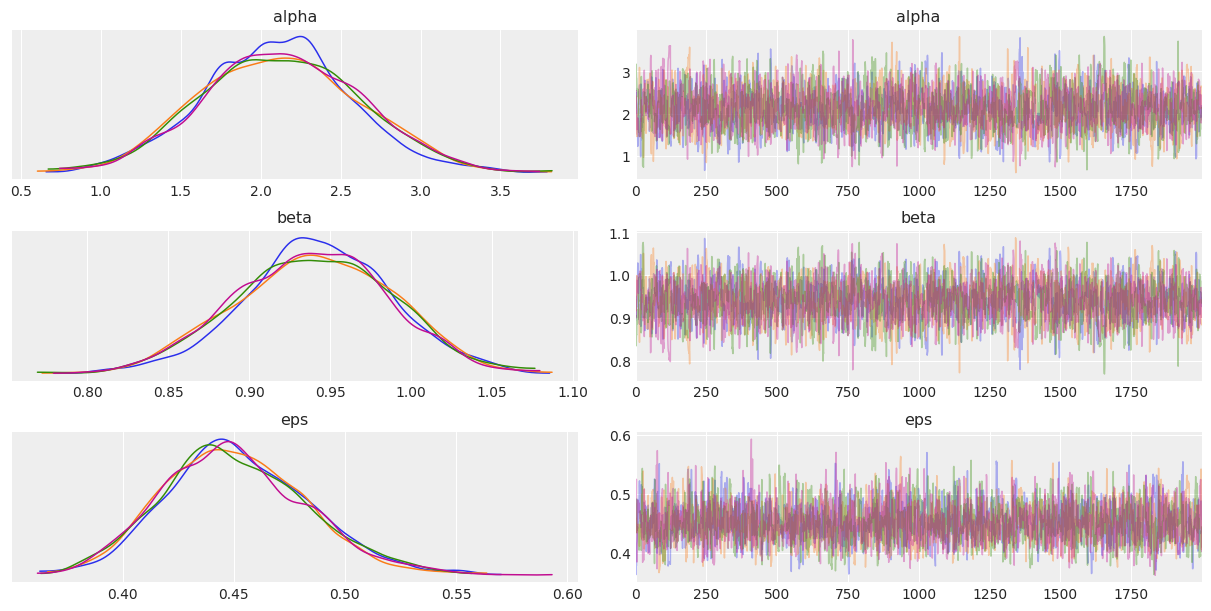

In [150]:
az.plot_trace(mcmc, var_names=['alpha', 'beta', 'eps']);

### SVI
#### Using an AutoGuide

In [200]:
autoguide = True
if autoguide:
    from numpyro.infer.autoguide import AutoDiagonalNormal
    guide = AutoDiagonalNormal(model_g)
else:
    from torch.distributions import constraints
    #### ????
    def guide(x, y):
        alpha_loc = numpyro.param('alpha_loc', 0.0)
        alpha_scale = numpyro.param('alpha_scale', 1.0, constraint=constraints.positive)
        eps_loc = numpyro.param('eps_loc', 1.0, constraint=constraints.positive)
        beta_loc = numpyro.param('beta_loc', 0.0)
        beta_scale = numpyro.param('beta_scale', 1.0, constraint=constraints.positive)
        
        alpha = numpyro.sample("alpha", dist.Normal(alpha_loc, alpha_scale))
        beta = numpyro.sample("beta", dist.Normal(beta_loc, beta_scale))
        eps = numpyro.sample("eps", dist.Normal(eps_loc, 0.05))
        mu = alpha + beta * x

In [201]:
# optimizing
from numpyro.infer import SVI, Trace_ELBO

adam = numpyro.optim.Adam(1) #({"lr": 0.03})
svi = SVI(model_g, 
          guide, adam, loss=Trace_ELBO(), x=x, y=y)

In [202]:
num_iterations = 2000

In [203]:
%%time
init_state = svi.init(random.PRNGKey(0))
state = lax.fori_loop(0, num_iterations, lambda i, x: svi.update(x)[0], init_state)
params = svi.get_params(state)

CPU times: user 979 ms, sys: 10.8 ms, total: 990 ms
Wall time: 967 ms


In [206]:
params

{'auto_loc': DeviceArray([ 2.1449144 ,  0.96977156, -0.4051745 ], dtype=float32),
 'auto_scale': DeviceArray([0.03296589, 0.00309975, 0.03580933], dtype=float32)}

### interpreting the posterior

In [121]:
def plot_posterior_2(x, y, posterior_samples):
    alpha_m = posterior_samples['alpha'].mean()
    beta_m = posterior_samples['beta'].mean()
    
    posterior_mu = jnp.expand_dims(posterior_samples['alpha'], -1) + jnp.expand_dims(posterior_samples['beta'], -1) * x
    mean_mu = jnp.mean(posterior_mu, axis=0)
    hpdi_mu = hpdi(posterior_mu, 0.9)
    
    idx = jnp.argsort(x)
    x = x[idx]
    y = y[idx]
    mean_mu = mean_mu[idx]
    hpdi_mu = hpdi_mu[:, idx]
    
    plt.plot(x, y, 'C0.')

    plt.fill_between(x, hpdi_mu[0], hpdi_mu[1], alpha=0.3, interpolate=True, color='k')
    plt.plot(x, alpha_m + beta_m * x, c='k', label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    plt.xlabel('x')
    plt.ylabel('y', rotation=0)
    plt.legend()
#     plt.savefig('B11197_03_05.png', dpi=300)

#### MCMC

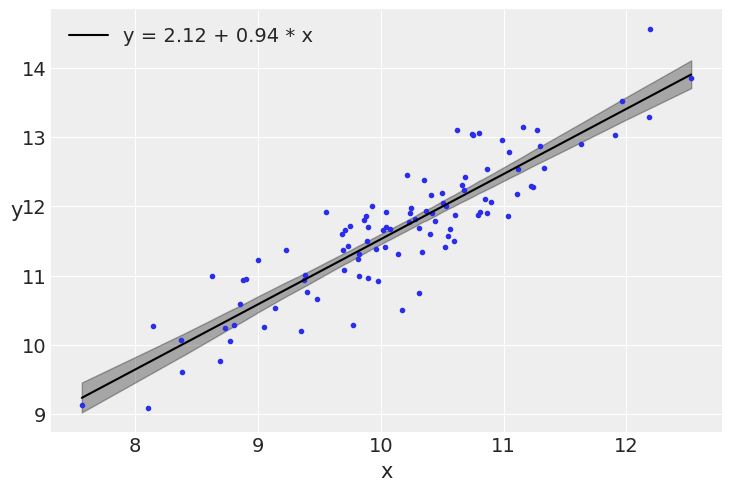

In [122]:
plot_posterior_2(x, y, posterior_samples)

In [129]:
def plot_posterior_3(x, y, posterior_samples, posterior_predictive):
    alpha_m = posterior_samples['alpha'].mean()
    beta_m = posterior_samples['beta'].mean()
    
    mean_pred = jnp.mean(posterior_predictive['obs'], axis=0)
    hpdi_pred = hpdi(posterior_predictive['obs'], 0.9)
    hpdi_pred_2 = hpdi(posterior_predictive['obs'], 0.5)
    
    idx = jnp.argsort(x)
    x = x[idx]
    y = y[idx]
    mean_pred = mean_pred[idx]
    hpdi_pred = hpdi_pred[:, idx]
    hpdi_pred_2 = hpdi_pred_2[:, idx]
    
    plt.plot(x, y, 'C0.')

    plt.fill_between(x, hpdi_pred[0], hpdi_pred[1], alpha=0.3, interpolate=True, color='k')
    plt.fill_between(x, hpdi_pred_2[0], hpdi_pred_2[1], alpha=0.3, interpolate=True, color='k')
    plt.plot(x, alpha_m + beta_m * x, c='k', label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    plt.xlabel('x')
    plt.ylabel('y', rotation=0)
    plt.legend()
#     plt.savefig('B11197_03_05.png', dpi=300)

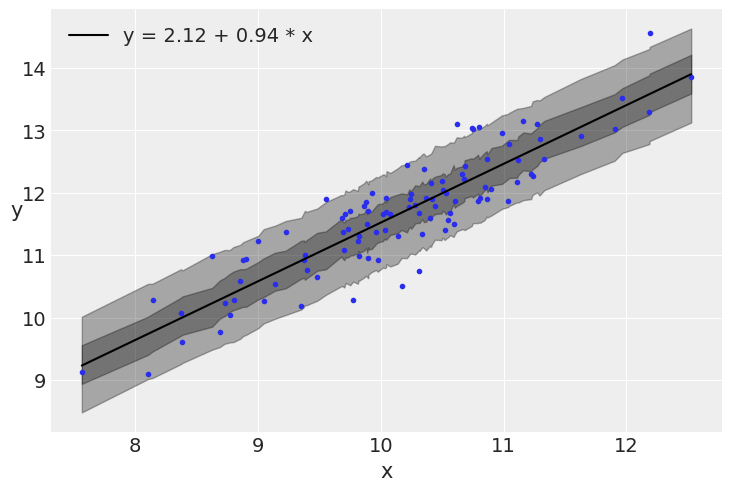

In [130]:
# MCMC
plot_posterior_3(x, y, posterior_samples, posterior_predictive)

### The multivariate normal distribution 
Actually the bivariate

In [5]:
# sigma_x1 = 1
# sigmas_x2 = [1, 2]
# rhos = [-0.90, -0.5, 0, 0.5, 0.90]

# k, l = np.mgrid[-5:5:.1, -5:5:.1]
# pos = np.empty(k.shape + (2,))
# pos[:, :, 0] = k
# pos[:, :, 1] = l

# f, ax = plt.subplots(len(sigmas_x2), len(rhos),
#                      sharex=True, sharey=True, figsize=(12, 6),
#                      constrained_layout=True)
# for i in range(2):
#     for j in range(5):
#         sigma_x2 = sigmas_x2[i]
#         rho = rhos[j]
#         cov = [[sigma_x1**2, sigma_x1*sigma_x2*rho],
#                [sigma_x1*sigma_x2*rho, sigma_x2**2]]
#         rv = stats.multivariate_normal([0, 0], cov)
#         ax[i, j].contour(k, l, rv.pdf(pos))
#         ax[i, j].set_xlim(-8, 8)
#         ax[i, j].set_ylim(-8, 8)
#         ax[i, j].set_yticks([-5, 0, 5])
#         ax[i, j].plot(0, 0,
#                       label=f'$\\sigma_{{x2}}$ = {sigma_x2:3.2f}\n$\\rho$ = {rho:3.2f}', alpha=0)
#         ax[i, j].legend()
# f.text(0.5, -0.05, 'x_1', ha='center', fontsize=18)
# f.text(-0.05, 0.5, 'x_2', va='center', fontsize=18, rotation=0)
# plt.savefig('B11197_03_08.png', dpi=300)

In [6]:
# %%time
# data = np.stack((x, y)).T
# with pm.Model() as pearson_model:

#     mu = pm.Normal('mu', mu=data.mean(0), sd=10, shape=2)

#     σ_1 = pm.HalfNormal('σ_1', 10)
#     σ_2 = pm.HalfNormal('σ_2', 10)
#     ρ = pm.Uniform('ρ', -1., 1.)
#     r2 = pm.Deterministic('r2', ρ**2)

#     cov = pm.math.stack(([σ_1**2, σ_1*σ_2*ρ],
#                          [σ_1*σ_2*ρ, σ_2**2]))

#     obs = pm.MvNormal('obs', mu=mu, cov=cov, observed=data)

#     trace_p = pm.sample(1000)

In [ ]:
# type(trace_p)

In [ ]:
# az.plot_trace(trace_p, var_names=['r2'])
# plt.savefig('B11197_03_9.png', dpi=300)

In [ ]:
# az.summary(trace_p, var_names=['r2'])

## Robust linear regression

In [7]:
ans = pd.read_csv('../data/anscombe.csv')
x_3 = ans[ans.group == 'III']['x'].values
y_3 = ans[ans.group == 'III']['y'].values
x_3 = x_3 - x_3.mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  if sys.path[0] == '':


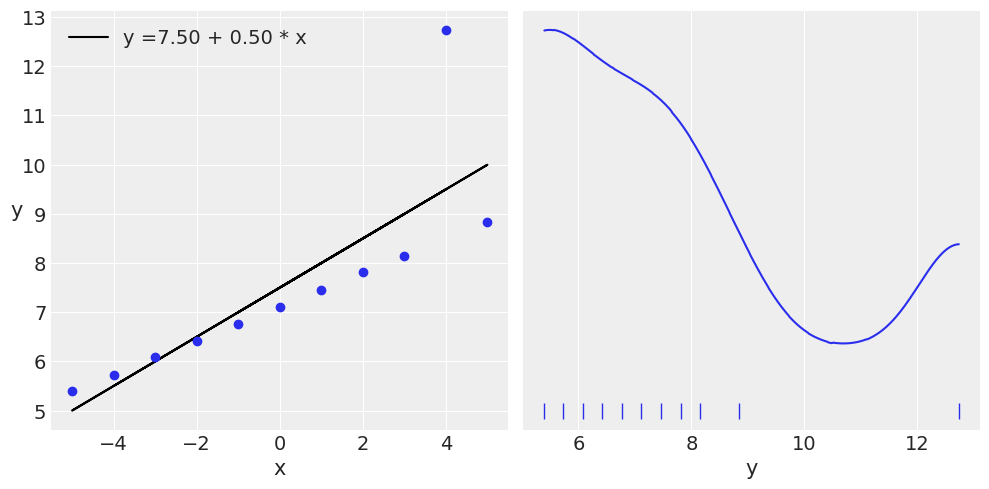

In [8]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
ax[0].plot(x_3, (alpha_c + beta_c * x_3), 'k',
           label=f'y ={alpha_c:.2f} + {beta_c:.2f} * x')
ax[0].plot(x_3, y_3, 'C0o')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].legend(loc=0)
az.plot_kde(y_3, ax=ax[1], rug=True)
ax[1].set_xlabel('y')
ax[1].set_yticks([])
plt.tight_layout()
plt.savefig('B11197_03_10.png', dpi=300)

In [9]:
y_3.mean()

7.5

In [10]:
def model_t(x, y=None):
    alpha = numpyro.sample('alpha', dist.Normal(loc=7.5, scale=1))
    beta = numpyro.sample('beta', dist.Normal(loc=0, scale=1))
    eps = numpyro.sample('eps', dist.HalfNormal(5.))
    nu_ = numpyro.sample('nu_', dist.Exponential(1/29))
    nu = nu_ + 1
    
    mu = alpha + beta * x
    
    numpyro.sample("obs", dist.StudentT(df=nu, loc=mu, scale=eps), obs=y)

In [11]:
rng_key = random.PRNGKey(0)
# rng_key, rng_key_ = random.split(rng_key)

In [12]:
x=jnp.array(x_3)
y=jnp.array(y_3)

### MCMC

In [14]:
%%time

nuts_kernel = NUTS(model_t)
mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=1000, num_chains=4)
mcmc.run(rng_key, x, y)
posterior_samples = mcmc.get_samples()

CPU times: user 5.65 s, sys: 2.11 ms, total: 5.65 s
Wall time: 5.38 s


In [15]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      7.11      0.00      7.11      7.11      7.12   3318.25      1.00
      beta      0.35      0.00      0.35      0.34      0.35   1502.85      1.01
       eps      0.00      0.00      0.00      0.00      0.01    220.62      1.02
       nu_      0.19      0.19      0.13      0.00      0.45    683.51      1.01

Number of divergences: 0


In [16]:
posterior_samples

{'alpha': DeviceArray([7.1155434, 7.11536  , 7.115048 , ..., 7.1139994, 7.1136155,
              7.114668 ], dtype=float32),
 'beta': DeviceArray([0.34505287, 0.34497783, 0.34530744, ..., 0.34551194,
              0.3447644 , 0.34576973], dtype=float32),
 'eps': DeviceArray([0.00139414, 0.00172337, 0.00188704, ..., 0.00190225,
              0.00141277, 0.00166291], dtype=float32),
 'nu_': DeviceArray([0.17724061, 0.15752399, 0.14010938, ..., 0.02797722,
              0.23909086, 0.21797302], dtype=float32)}

In [17]:
predictive = Predictive(model_t, posterior_samples)
posterior_predictive = predictive(random.PRNGKey(1), x=x)
posterior_predictive

{'obs': DeviceArray([[7.457469 , 6.7697196, 8.492485 , ..., 8.149778 , 6.426672 ,
               5.739614 ],
              [7.463163 , 6.768723 , 8.4948015, ..., 8.149331 , 6.4229364,
               5.7325473],
              [7.458288 , 6.769497 , 8.500416 , ..., 8.150111 , 6.425477 ,
               5.732907 ],
              ...,
              [7.4582286, 6.767403 , 8.496003 , ..., 8.148617 , 6.420714 ,
               5.725994 ],
              [7.4692116, 6.7684355, 8.492802 , ..., 8.155179 , 6.427281 ,
               5.7308345],
              [7.462213 , 6.7690115, 8.49817  , ..., 8.153901 , 6.4234037,
               5.721862 ]], dtype=float32)}

### Summary table

#### version 1

In [19]:
get_summary_table(posterior_predictive, ['obs'])

{'obs':         mean       std    median      5.0%     95.0%
 0   7.461402  0.412001  7.459627  7.443176  7.474598
 1   6.768881  0.081291  6.769140  6.753014  6.782598
 2   8.496353  0.062257  8.495304  8.480103  8.510188
 3   7.114928  0.108570  7.114467  7.098499  7.127016
 4   7.805055  0.239878  7.804849  7.791561  7.821228
 5   8.840253  0.099384  8.840459  8.825817  8.857586
 6   6.126832  4.188252  6.078876  6.063390  6.092525
 7   5.383433  0.383270  5.388224  5.371972  5.402676
 8   8.151420  0.112705  8.150114  8.134638  8.165616
 9   6.421668  0.202411  6.423958  6.409105  6.438334
 10  5.737284  0.372852  5.733425  5.717885  5.747386}

In [20]:
get_summary_table(posterior_samples, ['alpha', 'beta', 'eps'])

{'alpha':        mean       std    median      5.0%     95.0%
 0  7.114259  0.001366  7.114419  7.111713  7.116139,
 'beta':        mean      std    median      5.0%     95.0%
 0  0.345289  0.00042  0.345233  0.344688  0.345981,
 'eps':        mean       std    median      5.0%     95.0%
 0  0.003059  0.001705  0.002789  0.000547  0.005144}

#### version 2

In [22]:
get_summary_table_pandas(posterior_predictive, ['obs'], percentiles=[.05, 0.95])

{'obs':      count      mean       std        min        5%       50%       95%  \
 0   8000.0  7.461363  0.412007  -9.481285  7.443978  7.459627  7.475511   
 1   8000.0  6.768897  0.081291   4.884489  6.753362  6.769140  6.783269   
 2   8000.0  8.496318  0.062258   6.887022  8.480600  8.495305  8.510983   
 3   8000.0  7.114950  0.108571   1.496199  7.099519  7.114467  7.128555   
 4   8000.0  7.805078  0.239880  -6.770350  7.790339  7.804849  7.820466   
 5   8000.0  8.840238  0.099384   2.328917  8.824524  8.840459  8.856327   
 6   8000.0  6.126826  4.188461   5.194145  6.064084  6.078876  6.093402   
 7   8000.0  5.383432  0.383280 -28.535839  5.372356  5.388223  5.403188   
 8   8000.0  8.151430  0.112706   5.848412  8.133782  8.150114  8.164955   
 9   8000.0  6.421670  0.202412 -10.910456  6.409574  6.423958  6.439085   
 10  8000.0  5.737289  0.372854   4.553252  5.717577  5.733425  5.747097   
 
            max  
 0    38.349476  
 1    12.745357  
 2    11.529182  
 3    1

In [23]:
get_summary_table_pandas(posterior_samples, ['alpha', 'beta', 'eps'], percentiles=[.05, 0.95])

{'alpha':     count      mean       std       min        5%       50%       95%  \
 0  8000.0  7.114259  0.001366  7.103619  7.111866  7.114419  7.116329   
 
         max  
 0  7.121089  ,
 'beta':     count      mean      std       min        5%       50%       95%      max
 0  8000.0  0.345289  0.00042  0.342694  0.344716  0.345233  0.346021  0.34798,
 'eps':     count      mean       std       min        5%       50%       95%  \
 0  8000.0  0.003059  0.001705  0.000547  0.000651  0.002789  0.006139   
 
         max  
 0  0.019722  }

### plot trace

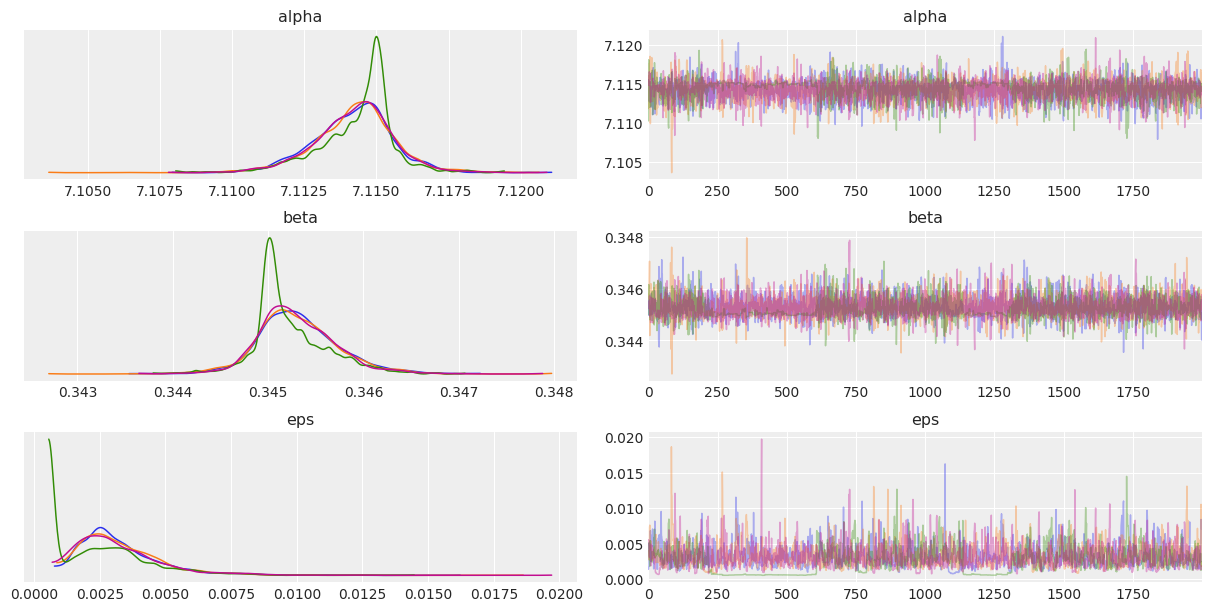

In [24]:
az.plot_trace(mcmc, var_names=['alpha', 'beta', 'eps']);

#### output

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  


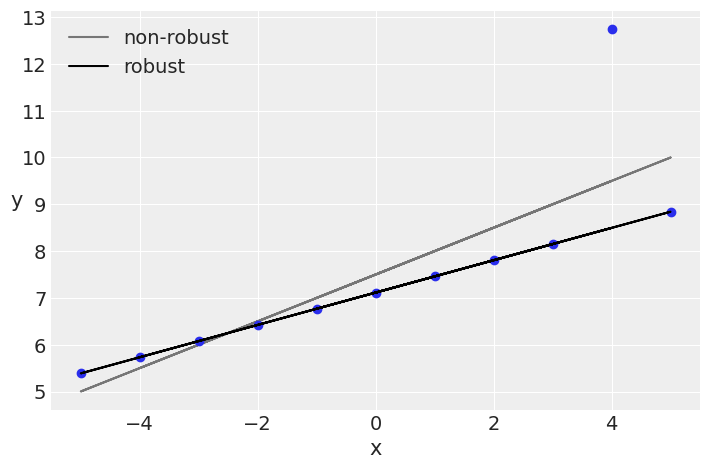

In [25]:
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]

plt.plot(x_3, (alpha_c + beta_c * x_3), 'k', label='non-robust', alpha=0.5)
plt.plot(x_3, y_3, 'C0o')


alpha_m = get_summary_table(posterior_samples, ['alpha'], diagnostics=False, group_by_chain=False, prob=0.9)['alpha']['mean'].values[0]
beta_m = get_summary_table(posterior_samples, ['beta'], diagnostics=False, group_by_chain=False, prob=0.9)['beta']['mean'].values[0]
plt.plot(x_3, alpha_m + beta_m * x_3, c='k', label='robust')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc=2)
plt.tight_layout()

# plt.savefig('B11197_03_11.png', dpi=300)

In [31]:
num_samples=2000
rng_key = random.PRNGKey(2)
prior = Predictive(model_t, num_samples=num_samples)(rng_key, x, y)
prior

{'alpha': DeviceArray([8.079369 , 7.4470816, 8.395457 , ..., 7.19967  , 7.310388 ,
              6.578183 ], dtype=float32),
 'beta': DeviceArray([ 0.14036971, -0.6908879 ,  2.1257734 , ..., -0.5412535 ,
               0.41758457, -0.8103888 ], dtype=float32),
 'eps': DeviceArray([4.448942 , 3.9940827, 3.1489158, ..., 3.5988271, 2.2187626,
              6.7866354], dtype=float32),
 'nu_': DeviceArray([ 1.3972224, 22.770931 , 41.05698  , ...,  0.5059992,
              64.386086 , 50.6426   ], dtype=float32),
 'obs': DeviceArray([[ 7.46,  6.77, 12.74, ...,  8.15,  6.42,  5.73],
              [ 7.46,  6.77, 12.74, ...,  8.15,  6.42,  5.73],
              [ 7.46,  6.77, 12.74, ...,  8.15,  6.42,  5.73],
              ...,
              [ 7.46,  6.77, 12.74, ...,  8.15,  6.42,  5.73],
              [ 7.46,  6.77, 12.74, ...,  8.15,  6.42,  5.73],
              [ 7.46,  6.77, 12.74, ...,  8.15,  6.42,  5.73]],            dtype=float32)}

In [32]:
numpyro_data = az.from_numpyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive,
#     coords={"x": np.arange(x)},
#     dims={"theta": ["school"]},
)
numpyro_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

(0.0, 12.0)

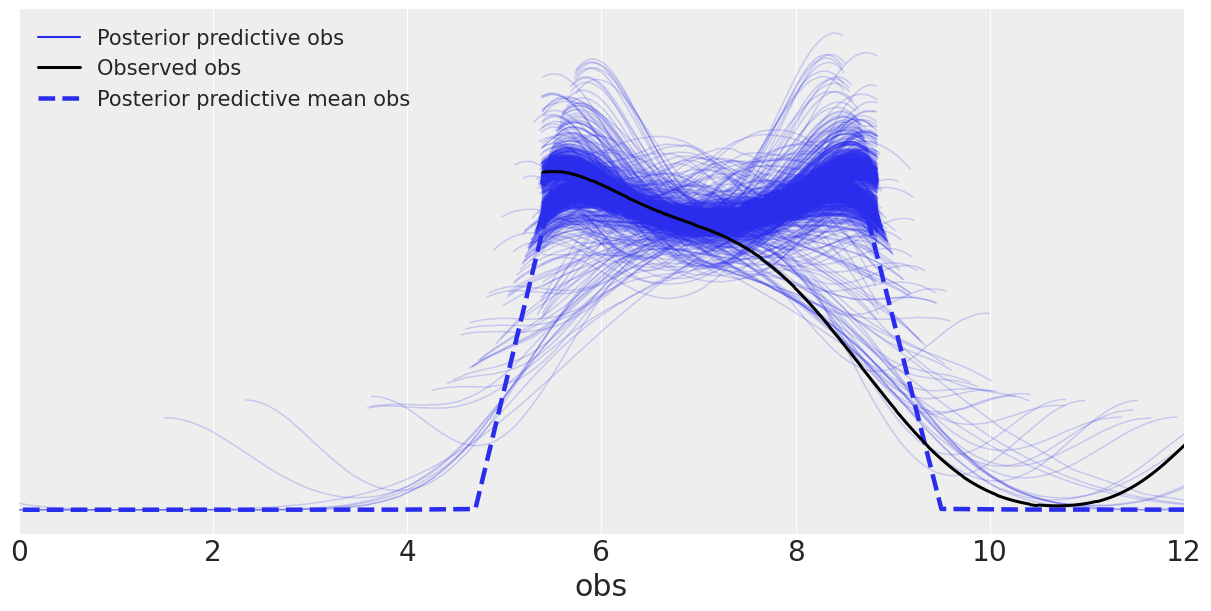

In [33]:
# data_ppc = az.from_pymc3(trace=trace_t, posterior_predictive=ppc)
ax = az.plot_ppc(numpyro_data, figsize=(12, 6), mean=True)
plt.xlim(0, 12)
# plt.savefig('B11197_03_12.png', dpi=300)

## Hierarchical linear regression

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


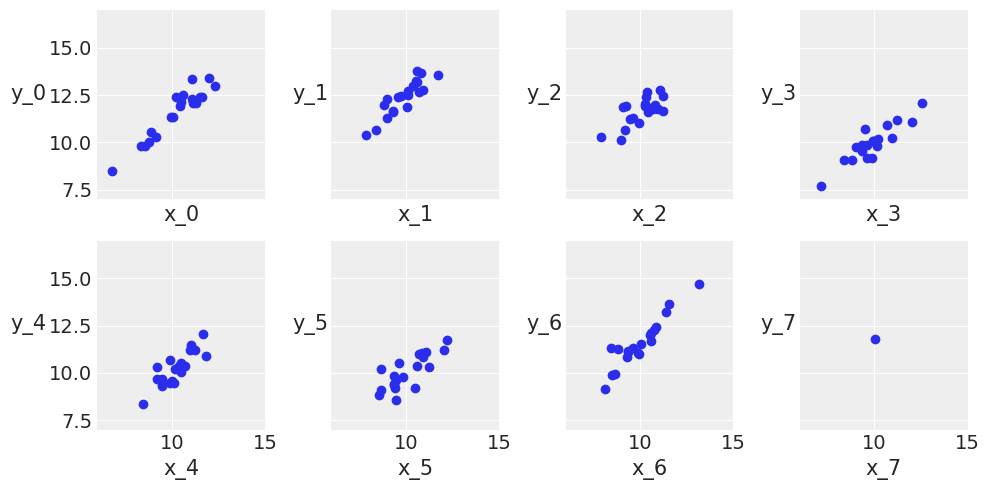

In [34]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real

_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', rotation=0, labelpad=15)
    ax[i].set_xlim(6, 15)
    ax[i].set_ylim(7, 17)
    j += N
    k += N
plt.tight_layout()
plt.savefig('B11197_03_13.png', dpi=300)

In [ ]:
x_centered = x_m - x_m.mean()

In [ ]:
with pm.Model() as unpooled_model:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10, shape=M)
    beta = pm.Normal('beta', mu=0, sd=10, shape=M)
    eps = pm.HalfCauchy('eps', 5)
    ν = pm.Exponential('ν', 1/30)

    obs = pm.StudentT('obs', mu=alpha_tmp[idx] + beta[idx] * x_centered,
                         sd=eps, nu=ν, observed=y_m)

    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_m.mean())

    trace_up = pm.sample(2000)

In [ ]:
az.plot_forest(trace_up, var_names=['alpha', 'beta'], combined=True)
plt.savefig('B11197_03_14.png', dpi=300)


 <img src='B11197_03_15.png' width="700">

In [ ]:
with pm.Model() as hierarchical_model:
    # hyper-priors
    alpha_mu_tmp = pm.Normal('alpha_mu_tmp', mu=0, sd=10)
    alpha_σ_tmp = pm.HalfNormal('alpha_σ_tmp', 10)
    beta_mu = pm.Normal('beta_mu', mu=0, sd=10)
    beta_σ = pm.HalfNormal('beta_σ', sd=10)

    # priors
    alpha_tmp = pm.Normal('alpha_tmp', mu=alpha_mu_tmp, sd=alpha_σ_tmp, shape=M)
    beta = pm.Normal('beta', mu=beta_mu, sd=beta_σ, shape=M)
    eps = pm.HalfCauchy('eps', 5)
    ν = pm.Exponential('ν', 1/30)

    obs = pm.StudentT('obs', mu=alpha_tmp[idx] + beta[idx] * x_centered,
                         sd=eps, nu=ν, observed=y_m)

    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_m.mean())
    alpha_mu = pm.Deterministic('alpha_mu', alpha_mu_tmp - beta_mu * x_m.mean())
    alpha_σ = pm.Deterministic('alpha_sd', alpha_σ_tmp - beta_mu * x_m.mean())

    trace_hm = pm.sample(1000)

In [ ]:
az.plot_forest(trace_hm, var_names=['alpha', 'beta'], combined=True)
plt.savefig('B11197_03_16.png', dpi=300)

In [ ]:
_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True,
                     constrained_layout=True)
ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    alpha_m = trace_hm['alpha'][:, i].mean()
    beta_m = trace_hm['beta'][:, i].mean()
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='k',
               label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N
plt.savefig('B11197_03_17.png', dpi=300)

## Polynomial regression

In [ ]:
x_2 = ans[ans.group == 'II']['x'].values
y_2 = ans[ans.group == 'II']['y'].values
x_2 = x_2 - x_2.mean()

plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.savefig('B11197_03_18.png', dpi=300)

In [ ]:
with pm.Model() as model_poly:
    alpha = pm.Normal('alpha', mu=y_2.mean(), sd=1)
    beta1 = pm.Normal('beta1', mu=0, sd=1)
    beta2 = pm.Normal('beta2', mu=0, sd=1)
    eps = pm.HalfCauchy('eps', 5)

    mu = alpha + beta1 * x_2 + beta2 * x_2**2

    obs = pm.Normal('obs', mu=mu, sd=eps, observed=y_2)

    trace_poly = pm.sample(2000)

In [ ]:
#az.plot_trace(trace_poly);

In [ ]:
#az.summary(trace_poly)

In [ ]:
x_p = np.linspace(-6, 6)
y_p = trace_poly['alpha'].mean() + trace_poly['beta1'].mean() * \
    x_p + trace_poly['beta2'].mean() * x_p**2
plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.plot(x_p, y_p, c='C1')
plt.savefig('B11197_03_19.png', dpi=300)

## Multiple Linear regression

In [ ]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)

X = np.array([np.random.normal(i, j, N) for i, j in zip([10, 2], [1, 1.5])]).T
X_mean = X.mean(axis=0, keepdims=True)
X_centered = X - X_mean
y = alpha_real + np.dot(X, beta_real) + eps_real

In [ ]:
def scatter_plot(x, y):
    plt.figure(figsize=(10, 10))
    for idx, x_i in enumerate(x.T):
        plt.subplot(2, 2, idx+1)
        plt.scatter(x_i, y)
        plt.xlabel(f'x_{idx+1}')
        plt.ylabel(f'y', rotation=0)

    plt.subplot(2, 2, idx+2)
    plt.scatter(x[:, 0], x[:, 1])
    plt.xlabel(f'x_{idx}')
    plt.ylabel(f'x_{idx+1}', rotation=0)

scatter_plot(X_centered, y)
plt.savefig('B11197_03_20.png', dpi=300)

In [ ]:
with pm.Model() as model_mlr:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=2)
    eps = pm.HalfCauchy('eps', 5)

    mu = alpha_tmp + pm.math.dot(X_centered, beta)

    alpha = pm.Deterministic('alpha', alpha_tmp - pm.math.dot(X_mean, beta))

    obs = pm.Normal('obs', mu=mu, sd=eps, observed=y)

    trace_mlr = pm.sample(2000)

In [ ]:
varnames = ['alpha', 'beta', 'eps']
#az.plot_trace(trace_mlr, var_names=varnames);

In [ ]:
az.summary(trace_mlr, var_names=varnames)

## Confounding variables and redundant variables

In [ ]:
np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=1)
#x_2 = x_1 + np.random.normal(size=N, scale=0.01)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T

In [ ]:
scatter_plot(X, y)
plt.savefig('B11197_03_21.png', dpi=300)

In [ ]:
with pm.Model() as m_x1x2:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta1 = pm.Normal('beta1', mu=0, sd=10)
    beta2 = pm.Normal('beta2', mu=0, sd=10)
    eps = pm.HalfCauchy('eps', 5)

    mu = alpha + beta1 * X[:, 0] + beta2 * X[:, 1]

    obs = pm.Normal('obs', mu=mu, sd=eps, observed=y)

    trace_x1x2 = pm.sample(2000)


with pm.Model() as m_x1:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta1 = pm.Normal('beta1', mu=0, sd=10)
    eps = pm.HalfCauchy('eps', 5)

    mu = alpha + beta1 * X[:, 0]

    obs = pm.Normal('obs', mu=mu, sd=eps, observed=y)

    trace_x1 = pm.sample(2000)

with pm.Model() as m_x2:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta2 = pm.Normal('beta2', mu=0, sd=10)
    eps = pm.HalfCauchy('eps', 5)

    mu = alpha + beta2 * X[:, 1]

    obs = pm.Normal('obs', mu=mu, sd=eps, observed=y)

    trace_x2 = pm.sample(2000)

In [ ]:
az.plot_forest([trace_x1x2, trace_x1, trace_x2],
               model_names=['m_x1x2', 'm_x1', 'm_x2'],
               var_names=['beta1', 'beta2'],
               combined=False, colors='cycle', figsize=(8, 3))
plt.savefig('B11197_03_22.png', dpi=300)

In [ ]:
# just repeating the code from a couple of cells before, but with a lower value of `scale`.
np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=0.01)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T

In [ ]:
scatter_plot(X, y)
plt.savefig('B11197_03_23.png', dpi=300)

In [ ]:
with pm.Model() as model_red:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    eps = pm.HalfCauchy('eps', 5)

    mu = alpha + pm.math.dot(X, beta)

    obs = pm.Normal('obs', mu=mu, sd=eps, observed=y)

    trace_red = pm.sample(2000)

In [ ]:
az.plot_forest(trace_red, var_names=['beta'], combined=True, figsize=(8, 2))
plt.savefig('B11197_03_24.png', dpi=300)

In [ ]:
az.plot_pair(trace_red, var_names=['beta'])
plt.savefig('B11197_03_25.png', dpi=300)

## Masking effect variables

In [ ]:
np.random.seed(42)
N = 126
r = 0.8
x_1 = np.random.normal(size=N)
x_2 = np.random.normal(x_1, scale=(1 - r ** 2) ** 0.5)
y = np.random.normal(x_1 - x_2)
X = np.vstack((x_1, x_2)).T

In [ ]:
scatter_plot(X, y)
plt.savefig('B11197_03_26.png', dpi=300, figsize=(5.5, 5.5))

In [ ]:
with pm.Model() as m_x1x2:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta1 = pm.Normal('beta1', mu=0, sd=10)
    beta2 = pm.Normal('beta2', mu=0, sd=10)
    eps = pm.HalfCauchy('eps', 5)

    mu = alpha + beta1 * X[:, 0] + beta2 * X[:, 1]

    obs = pm.Normal('obs', mu=mu, sd=eps, observed=y)

    trace_x1x2 = pm.sample(1000)


with pm.Model() as m_x1:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta1 = pm.Normal('beta1', mu=0, sd=10)
    eps = pm.HalfCauchy('eps', 5)

    mu = alpha + beta1 * X[:, 0]

    obs = pm.Normal('obs', mu=mu, sd=eps, observed=y)

    trace_x1 = pm.sample(1000)

with pm.Model() as m_x2:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta2 = pm.Normal('beta2', mu=0, sd=10)
    eps = pm.HalfCauchy('eps', 5)

    mu = alpha + beta2 * X[:, 1]

    obs = pm.Normal('obs', mu=mu, sd=eps, observed=y)

    trace_x2 = pm.sample(1000)

In [ ]:
az.plot_forest([trace_x1x2, trace_x1, trace_x2],
               model_names=['m_x1x2', 'm_x1', 'm_x2'],
               var_names=['beta1', 'beta2'],
               combined=True, colors='cycle', figsize=(8, 3))
plt.savefig('B11197_03_27.png', dpi=300, bbox_inches='tight')

## Variable variance

In [ ]:
data = pd.read_csv('../data/babies.csv')
data.plot.scatter('Month', 'Lenght')
plt.savefig('B11197_03_28.png', dpi=300)

In [ ]:
with pm.Model() as model_vv:
    alpha = pm.Normal('alpha', sd=10)
    beta = pm.Normal('beta', sd=10)
    γ = pm.HalfNormal('γ', sd=10)
    δ = pm.HalfNormal('δ', sd=10)

    x_shared = shared(data.Month.values * 1.)

    mu = pm.Deterministic('mu', alpha + beta * x_shared**0.5)
    eps = pm.Deterministic('eps', γ + δ * x_shared)

    obs = pm.Normal('obs', mu=mu, sd=eps, observed=data.Lenght)

    trace_vv = pm.sample(1000, tune=1000)

In [ ]:
plt.plot(data.Month, data.Lenght, 'C0.', alpha=0.1)

mu_m = trace_vv['mu'].mean(0)
eps_m = trace_vv['eps'].mean(0)

plt.plot(data.Month, mu_m, c='k')
plt.fill_between(data.Month, mu_m + 1 * eps_m, mu_m -
                 1 * eps_m, alpha=0.6, color='C1')
plt.fill_between(data.Month, mu_m + 2 * eps_m, mu_m -
                 2 * eps_m, alpha=0.4, color='C1')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.savefig('B11197_03_29.png', dpi=300)

In [ ]:
x_shared.set_value([0.5])
ppc = pm.sample_posterior_predictive(trace_vv, 2000, model=model_vv)
y_ppc = ppc['obs'][:, 0]

In [ ]:
ref = 53
density, l, u = az._fast_kde(y_ppc)
x_ = np.linspace(l, u, 200)
plt.plot(x_, density)
percentile = int(sum(y_ppc <= ref) / len(y_ppc) * 100)
plt.fill_between(x_[x_ < ref], density[x_ < ref],
                 label='percentile = {:2d}'.format(percentile))
plt.xlabel('length')
plt.yticks([])
plt.legend()
plt.savefig('B11197_03_30.png', dpi=300)

In [ ]:
x_4 = ans[ans.group == 'IV']['x'].values
y_4 = ans[ans.group == 'IV']['y'].values

with pm.Model() as model_t2:
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=1)
    eps = pm.HalfCauchy('eps', 5)
    ν = pm.Exponential('ν', 1/30)
    #ν = pm.Gamma('ν', mu=20, sd=15)
    #ν = pm.Gamma('ν', 2, 0.1)

    obs = pm.StudentT('obs', mu=alpha + beta * x_4, sd=eps, nu=ν, observed=y_4)
    trace_t2 = pm.sample(2000)